In [0]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    #TESTING = "PetImages/Testing"
    Bricks_1x1 = "/content/drive/My Drive/Cropped Images/Brick_1x1"
    Bricks_1x2 = "/content/drive/My Drive/Cropped Images/Brick_1x2"
    Bricks_1x3 = "/content/drive/My Drive/Cropped Images/Brick_1x3"
    LABELS = {Bricks_1x1: 0, Bricks_1x2: 1, Bricks_1x3: 2}
    training_data = []

    brick_1x1_count = 0
    brick_1x2_count = 0
    brick_1x3_count = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(3)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.Bricks_1x1:
                            self.brick_1x1_count += 1
                        elif label == self.Bricks_1x2:
                            self.brick_1x2_count += 1
                        elif label == self.Bricks_1x3:
                            self.brick_1x3_count += 1
                       
                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Bricks_1X1:',dogsvcats.brick_1x1_count)
        print('Bricks_1X2:',dogsvcats.brick_1x2_count)
        print('Bricks_1X3:',dogsvcats.brick_1x3_count)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

/content/drive/My Drive/Cropped Images/Brick_1x1


100%|██████████| 214/214 [01:13<00:00,  2.90it/s]


/content/drive/My Drive/Cropped Images/Brick_1x2


100%|██████████| 239/239 [01:22<00:00,  2.90it/s]


/content/drive/My Drive/Cropped Images/Brick_1x3


100%|██████████| 188/188 [01:01<00:00,  3.05it/s]

Bricks_1X1: 214
Bricks_1X2: 239
Bricks_1X3: 188


In [51]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

641


In [0]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

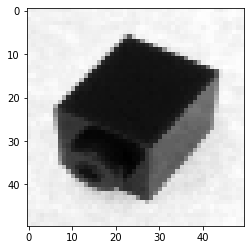

In [55]:
import matplotlib.pyplot as plt

plt.imshow(X[0], cmap="gray")

In [56]:
print(y[0])

tensor([1., 0., 0.])


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 3) # 512 in, 3 out bc we're doing 3 classes

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [0]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [59]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

64


In [60]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

577 64


In [61]:
for i in range(0,20):
  print(train_y[i])

tensor([1., 0., 0.])
tensor([1., 0., 0.])
tensor([0., 0., 1.])
tensor([0., 0., 1.])
tensor([0., 0., 1.])
tensor([0., 1., 0.])
tensor([0., 0., 1.])
tensor([1., 0., 0.])
tensor([0., 1., 0.])
tensor([0., 0., 1.])
tensor([1., 0., 0.])
tensor([0., 0., 1.])
tensor([1., 0., 0.])
tensor([1., 0., 0.])
tensor([1., 0., 0.])
tensor([0., 0., 1.])
tensor([0., 0., 1.])
tensor([1., 0., 0.])
tensor([0., 0., 1.])
tensor([0., 1., 0.])


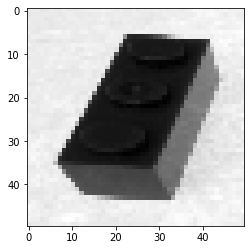

In [0]:
import matplotlib.pyplot as plt

#plt.imshow(train_X[0], cmap="gray")
#plt.imshow(train_X[1], cmap="gray")
#plt.imshow(train_X[2], cmap="gray")
#plt.imshow(train_X[3], cmap="gray")
plt.imshow(train_X[0], cmap="gray")
#plt.imshow(train_X[5], cmap="gray")
#plt.imshow(train_X[6], cmap="gray")

In [62]:
BATCH_SIZE = 5
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

  3%|▎         | 3/116 [00:00<00:04, 25.15it/s]

Epoch: 0. Loss: 0.1368013620376587


  3%|▎         | 3/116 [00:00<00:03, 28.71it/s]

Epoch: 1. Loss: 0.010253310203552246


  3%|▎         | 3/116 [00:00<00:04, 28.22it/s]

Epoch: 2. Loss: 0.0009144539944827557


  3%|▎         | 3/116 [00:00<00:04, 27.14it/s]

Epoch: 3. Loss: 0.0008675102726556361


100%|██████████| 116/116 [00:04<00:00, 28.30it/s]

Epoch: 4. Loss: 0.00021012325305491686


In [63]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])  
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)
        print("real",real_class,"predicted",predicted_class)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

 78%|███████▊  | 50/64 [00:00<00:00, 230.80it/s]

real tensor(0) predicted tensor(0)
real tensor(0) predicted tensor(0)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(0) predicted tensor(0)
real tensor(0) predicted tensor(0)
real tensor(0) predicted tensor(0)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(0) predicted tensor(0)
real tensor(1) predicted tensor(1)
real tensor(0) predicted tensor(0)
real tensor(1) predicted tensor(1)
real tensor(0) predicted tensor(0)
real tensor(0) predicted tensor(0)
real tensor(0) predicted tensor(0)
real tensor(2) predicted tensor(2)
real tensor(2) predicted tensor(2)
real tensor(0) predicted tensor(0)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(1) predi

100%|██████████| 64/64 [00:00<00:00, 251.81it/s]

real tensor(0) predicted tensor(0)
real tensor(0) predicted tensor(0)
real tensor(2) predicted tensor(2)
real tensor(1) predicted tensor(1)
real tensor(0) predicted tensor(0)
real tensor(1) predicted tensor(1)
real tensor(1) predicted tensor(1)
real tensor(0) predicted tensor(0)
real tensor(0) predicted tensor(0)
real tensor(2) predicted tensor(2)
real tensor(1) predicted tensor(1)
real tensor(2) predicted tensor(2)
real tensor(2) predicted tensor(2)
real tensor(0) predicted tensor(0)
Accuracy:  0.953
